## 单个隐藏层，全连接自编码器把768维度的图像压缩到32维度，然后用随机森林对这32维度的向量进行标签的分类预测

### 1.载入包

In [5]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


### 2.超参数设定

In [2]:
CONFIG = {
    'random_seed': 42,
    'lr': 0.001,
    'epochs': 10,
    'batch_size': 512,
    'n_feature': 28 * 28,
    'n_hidden': 32,
    'data_path': 'D:/TPSTUDIO/00practice/deeplearning-models/pytorch_ipynb/autoencoder/data',
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

### 3.加载数据

In [4]:
def get_dataloaders(config):
    # num_workers > 0 利用多进程加载数据，pin_memory=Tru加速CPU到GPU的数据传输
    train_dataset = datasets.MNIST(root=config['data_path'], train=True,
                                   transform=transforms.ToTensor(), download=True)
    test_dataset = datasets.MNIST(root=config['data_path'], train=False,
                                  transform=transforms.ToTensor(), download=True)

    kwargs = {'num_workers': 2, 'pin_memory': True} if config['device'].type == 'cuda' else {}

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, **kwargs)

    return train_loader, test_loader

### 4.模型架构

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),  # [Batch, 1, 28, 28]
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.1) # 指定斜率
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 5.训练模型

In [7]:
def train(model, train_loader, optimizer, criterion, epoch, config):
    model.train()
    start_time = time.time()

    for batch_idx, (features, _) in enumerate(train_loader):
        # features已经在模型内部Flatten了，这里直接传
        features = features.to(config['device'], non_blocking=True)

        # Forward
        logits = model(features)
        cost = criterion(logits, features.view(-1, config['n_feature']))

        # Backward
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if not batch_idx % 50:
            print(f"Epoch: {epoch:03d}/{config['epochs']:03d} | Batch {batch_idx:03d}/{len(train_loader):03d} | Cost: {cost.item():.4f}")

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

In [15]:
def main():
    set_seed(CONFIG['random_seed'])
    print(f"Using device: {CONFIG['device']}")

    train_loader, test_loader = get_dataloaders(CONFIG)

    model = Autoencoder(CONFIG['n_feature'], CONFIG['n_hidden']).to(CONFIG['device'])
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])

    criterion = nn.BCEWithLogitsLoss()

    total_start = time.time()
    for i in range(1, CONFIG['epochs'] + 1):
        train(model, train_loader, optimizer, criterion, i, CONFIG)

    print(f'Total Training Time: {(time.time() - total_start)/60:.2f} min')
    return model, train_loader, test_loader

trained_model, train_loader, test_loader = main()

Using device: cuda:0
Epoch: 001/010 | Batch 000/118 | Cost: 0.6966
Epoch: 001/010 | Batch 050/118 | Cost: 0.3176
Epoch: 001/010 | Batch 100/118 | Cost: 0.2719
Time elapsed: 0.10 min
Epoch: 002/010 | Batch 000/118 | Cost: 0.2600
Epoch: 002/010 | Batch 050/118 | Cost: 0.2368
Epoch: 002/010 | Batch 100/118 | Cost: 0.2171
Time elapsed: 0.10 min
Epoch: 003/010 | Batch 000/118 | Cost: 0.2102
Epoch: 003/010 | Batch 050/118 | Cost: 0.2004
Epoch: 003/010 | Batch 100/118 | Cost: 0.1872
Time elapsed: 0.10 min
Epoch: 004/010 | Batch 000/118 | Cost: 0.1834
Epoch: 004/010 | Batch 050/118 | Cost: 0.1746
Epoch: 004/010 | Batch 100/118 | Cost: 0.1724
Time elapsed: 0.10 min
Epoch: 005/010 | Batch 000/118 | Cost: 0.1694
Epoch: 005/010 | Batch 050/118 | Cost: 0.1625
Epoch: 005/010 | Batch 100/118 | Cost: 0.1592
Time elapsed: 0.10 min
Epoch: 006/010 | Batch 000/118 | Cost: 0.1543
Epoch: 006/010 | Batch 050/118 | Cost: 0.1561
Epoch: 006/010 | Batch 100/118 | Cost: 0.1470
Time elapsed: 0.10 min
Epoch: 007/01

### 6.评估模型

Visualizing Training Data...


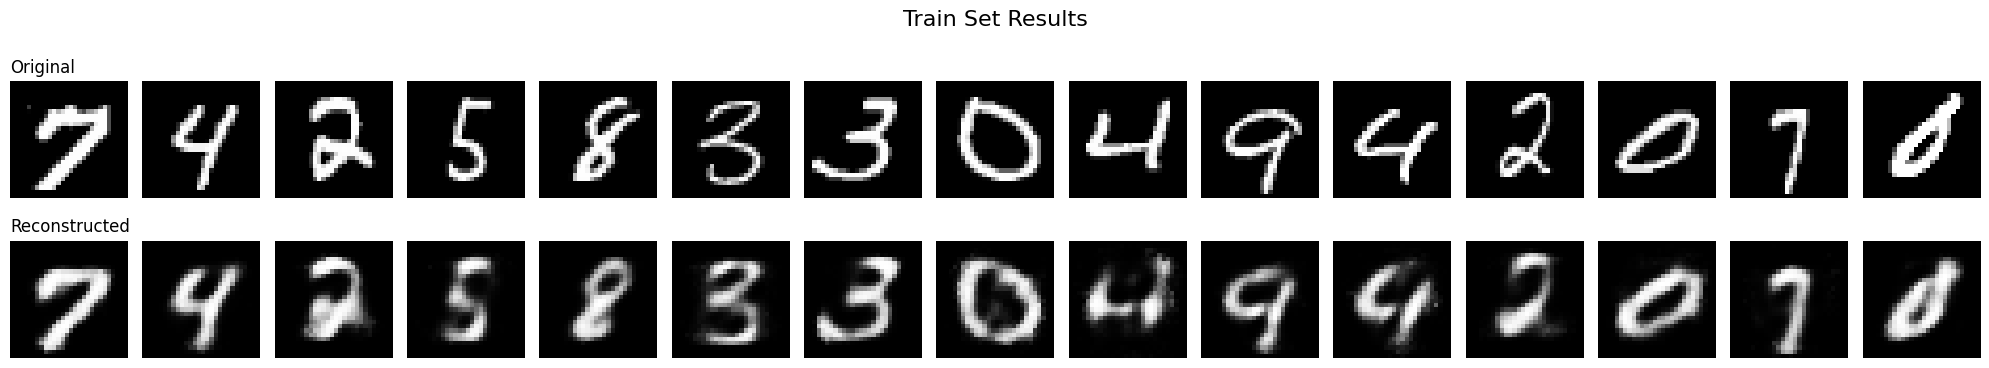

Visualizing Test Data...


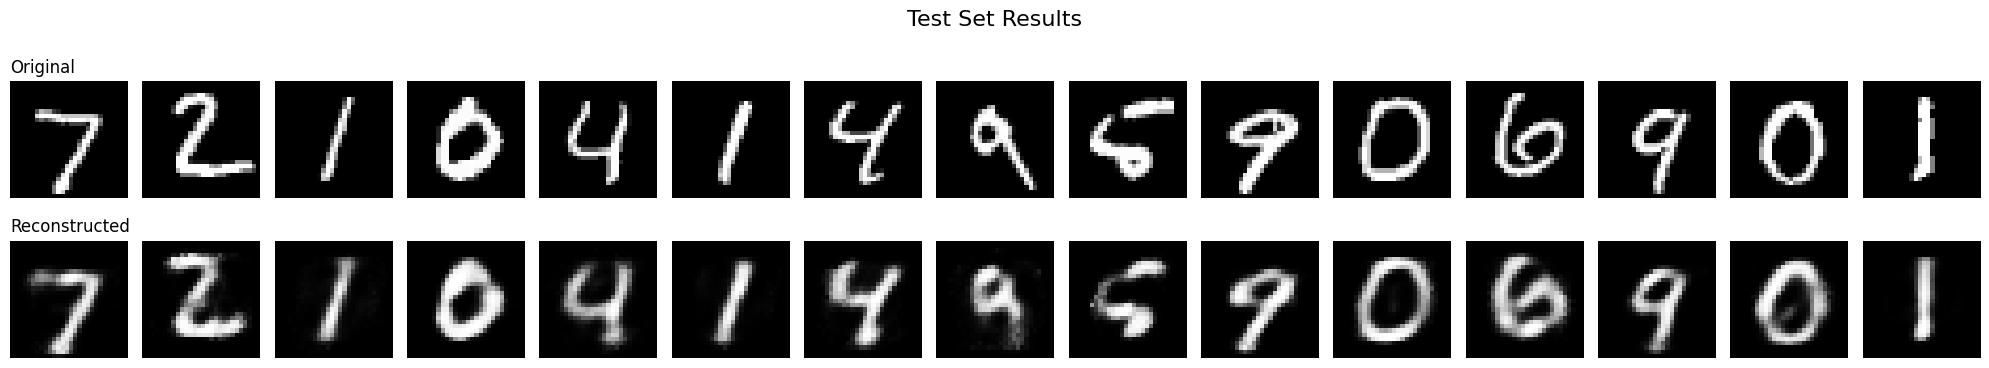

In [16]:
import matplotlib.pyplot as plt

def visualize_results(model, loader, device, title_prefix="Test", n_images=15):
    model.eval()

    # 获取一个批次的数据
    images, _ = next(iter(loader))
    images = images[:n_images].to(device)

    # 模型推理
    with torch.no_grad():
        # 加 sigmoid才能把像素值还原[0, 1]区间用于显示
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

    # [N, 1, 28, 28] -> [N, 28, 28]
    orig_imgs = images.cpu().squeeze(1).numpy()
    recon_imgs = outputs.cpu().view(-1, 28, 28).numpy()

    # 绘图
    fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))

    fig.suptitle(f'{title_prefix} Set Results', fontsize=16)

    for i in range(n_images):
        # 第一行：原始图像
        axes[0, i].imshow(orig_imgs[i], cmap='gray')
        axes[0, i].axis('off')

        # 第二行：重建图像
        axes[1, i].imshow(recon_imgs[i], cmap='gray')
        axes[1, i].axis('off')

    # 给第一列加上行标题
    axes[0, 0].set_title('Original', fontsize=12, loc='left')
    axes[1, 0].set_title('Reconstructed', fontsize=12, loc='left')

    plt.tight_layout()
    plt.show()

# 1. 查看训练集上的效果 (检查模型是否拟合)
print("Visualizing Training Data...")
visualize_results(trained_model, train_loader, CONFIG['device'], title_prefix="Train", n_images=15)

# 2. 查看测试集上的效果 (检查模型泛化能力)
print("Visualizing Test Data...")
visualize_results(trained_model, test_loader, CONFIG['device'], title_prefix="Test", n_images=15)

### 7.sklearn 随机森林分类器对压缩数据encoder（就是隐向量），来做标签分类训练

In [17]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

def get_latent_features(model, loader, device):
    model.eval()
    latent_vectors = []
    labels_list = []

    print("Extracting features...")
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)

            # 直接传入images，因为我model.encoder第一层是Flatten
            encoded = model.encoder(images)
            latent_vectors.append(encoded.cpu().numpy())
            labels_list.append(targets.numpy())

    # 将所有 batch 的数据拼接成一个大数组
    # X shape: (总样本数, 32), y shape: (总样本数,)
    X = np.concatenate(latent_vectors, axis=0)
    y = np.concatenate(labels_list, axis=0)

    return X, y

In [18]:
X_train, y_train = get_latent_features(trained_model, train_loader, CONFIG['device'])
X_test, y_test = get_latent_features(trained_model, test_loader, CONFIG['device'])
print(f"Feature extraction complete.")
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Extracting features...
Extracting features...
Feature extraction complete.
Train Shape: (60000, 32), Test Shape: (10000, 32)


In [19]:
X_train

array([[-0.28081453, -0.60146725,  3.0307221 , ...,  5.5409117 ,
        -0.3672453 ,  2.1600175 ],
       [-0.86680025, -2.755902  ,  2.2266724 , ...,  8.170601  ,
        -2.5239222 ,  1.8891106 ],
       [-0.80221385, -1.3317131 ,  8.016422  , ...,  8.986295  ,
        -0.76202136,  7.554187  ],
       ...,
       [-0.70514894, -1.3125776 , 10.932799  , ...,  5.858667  ,
        -1.6601692 ,  3.486276  ],
       [-2.5395346 , -0.8035079 , 20.69739   , ..., 11.578872  ,
        -2.566776  ,  4.7170258 ],
       [-0.9923069 , -1.4765664 ,  0.7395695 , ...,  7.4813023 ,
        -0.8296742 ,  3.9259088 ]], dtype=float32)

In [20]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)

print(f'RF Train Accuracy: {train_acc:.4f}')
print(f'RF Test Accuracy:  {test_acc:.4f}')

RF Train Accuracy: 1.0000
RF Test Accuracy:  0.9426


### 8.对比PCA，用PCA对图像进行特征提取，然后再进行分类预测训练

In [24]:
from sklearn.decomposition import PCA

In [25]:
def get_raw_flattened_data(loader):
    """
    不经过模型，直接从 Loader 中提取原始像素数据并拉平
    """
    data_list = []
    labels_list = []

    for images, targets in loader:
        # images shape: [batch, 1, 28, 28] -> [batch, 784]
        flattened = images.view(images.size(0), -1).numpy()
        data_list.append(flattened)
        labels_list.append(targets.numpy())

    X = np.concatenate(data_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

In [26]:
X_train_raw, y_train_raw = get_raw_flattened_data(train_loader)
X_test_raw, y_test_raw = get_raw_flattened_data(test_loader)

In [27]:
X_train_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
pca = PCA(n_components=32, random_state=42)

X_train_pca = pca.fit_transform(X_train_raw)
X_test_pca = pca.transform(X_test_raw)

# 查看解释方差比(Explained Variance Ratio),这代表了 32 个特征保留了原始数据多少的信息量
print(f"PCA Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.2%}")

PCA Explained Variance Ratio: 74.36%


In [29]:
print("Training Random Forest on PCA features...")
rf_pca = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_pca.fit(X_train_pca, y_train_raw)

Training Random Forest on PCA features...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
train_acc_pca = rf_pca.score(X_train_pca, y_train_raw)
print(f'PCA RF Train Accuracy: {train_acc_pca:.4f}')
test_acc_pca = rf_pca.score(X_test_pca, y_test_raw)
print(f'PCA RF Test Accuracy:  {test_acc_pca:.4f}')

PCA RF Train Accuracy: 1.0000
PCA RF Test Accuracy:  0.9538
